참고자료 : keras-ocr https://github.com/faustomorales/keras-ocr    
         Paper https://arxiv.org/pdf/1904.01941.pdf   
         Craft - keras https://github.com/notAI-tech/keras-craft   
         Craft - Pytorch https://github.com/clovaai/CRAFT-pytorch    
         
         
데이터 :MJ Synth https://drive.google.com/drive/folders/1xYcMdOMdP4N738hBTg6Pg-40vWf6jJz4


In [1]:
! mkdir -p ~/aiffel/ocr
! cd ~/aiffel/ocr

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [4]:
! pip install lmdb

     |████████████████████████████████| 876 kB 1.4 MB/s eta 0:00:01
  Created wheel for lmdb: filename=lmdb-1.0.0-cp37-cp37m-linux_x86_64.whl size=276825 sha256=cd2dc2ccc7b473bd2652d7b4c573c8d7bebdd46d481775b8eddaec49ae3ba162
  Stored in directory: /home/aiffel/.cache/pip/wheels/12/e2/8d/261e2b6143cc3e0e690ccc065af68e44c43c26bc903ffa5d69
Successfully built lmdb


In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


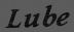

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


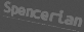

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


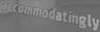

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


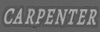

In [4]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [5]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    def _get_img_label(self, index):
        # Return image array and label in string
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

In [6]:
""" Convert between text-label and text-index """
class LabelConverter(object):
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

In [10]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 29.2686
Epoch 00001: val_loss improved from inf to 27.03360, saving model to /home/aiffel/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 9s 138ms/step - loss: 29.2686 - val_loss: 27.0336
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 26.4598
Epoch 00002: val_loss did not improve from 27.03360
63/63 [==============================] - 9s 148ms/step - loss: 26.4598 - val_loss: 27.7778
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 25.9432
Epoch 00003: val_loss improved from 27.03360 to 26.13649, saving model to /home/aiffel/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 125ms/step - loss: 25.9432 - val_loss: 26.1365
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 25.9045
Epoch 00004: val_loss did not improve from 26.13649
63/63 [==============================] - 8s 129ms/step - loss: 25.9045 - val_los

63/63 [==============================] - ETA: 0s - loss: 5.9758
Epoch 00031: val_loss did not improve from 6.25901
63/63 [==============================] - 8s 120ms/step - loss: 5.9758 - val_loss: 6.2908
Epoch 32/100
63/63 [==============================] - ETA: 0s - loss: 5.8567
Epoch 00032: val_loss improved from 6.25901 to 5.78969, saving model to /home/aiffel/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 121ms/step - loss: 5.8567 - val_loss: 5.7897
Epoch 33/100
63/63 [==============================] - ETA: 0s - loss: 5.5693
Epoch 00033: val_loss did not improve from 5.78969
63/63 [==============================] - 8s 123ms/step - loss: 5.5693 - val_loss: 5.9052
Epoch 34/100
63/63 [==============================] - ETA: 0s - loss: 5.5676
Epoch 00034: val_loss did not improve from 5.78969
63/63 [==============================] - 7s 119ms/step - loss: 5.5676 - val_loss: 6.1111
Epoch 35/100
63/63 [==============================] - ETA: 0s - loss: 5.3568
E

Epoch 63/100
63/63 [==============================] - ETA: 0s - loss: 3.8114
Epoch 00063: val_loss did not improve from 3.90443
63/63 [==============================] - 8s 120ms/step - loss: 3.8114 - val_loss: 4.0190
Epoch 64/100
63/63 [==============================] - ETA: 0s - loss: 3.6128
Epoch 00064: val_loss improved from 3.90443 to 3.80661, saving model to /home/aiffel/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 121ms/step - loss: 3.6128 - val_loss: 3.8066
Epoch 65/100
63/63 [==============================] - ETA: 0s - loss: 3.5768
Epoch 00065: val_loss improved from 3.80661 to 3.70676, saving model to /home/aiffel/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 122ms/step - loss: 3.5768 - val_loss: 3.7068
Epoch 66/100
63/63 [==============================] - ETA: 0s - loss: 3.6756
Epoch 00066: val_loss did not improve from 3.70676
63/63 [==============================] - 8s 120ms/step - loss: 3.6756 - val_loss: 3.771

63/63 [==============================] - ETA: 0s - loss: 2.9389
Epoch 00097: val_loss did not improve from 3.08851
63/63 [==============================] - 8s 119ms/step - loss: 2.9389 - val_loss: 3.0920
Epoch 98/100
63/63 [==============================] - ETA: 0s - loss: 2.8815
Epoch 00098: val_loss did not improve from 3.08851
63/63 [==============================] - 7s 119ms/step - loss: 2.8815 - val_loss: 3.1844
Epoch 99/100
63/63 [==============================] - ETA: 0s - loss: 3.0725
Epoch 00099: val_loss improved from 3.08851 to 3.04125, saving model to /home/aiffel/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 121ms/step - loss: 3.0725 - val_loss: 3.0413
Epoch 100/100
63/63 [==============================] - ETA: 0s - loss: 3.0241
Epoch 00100: val_loss did not improve from 3.04125
63/63 [==============================] - 8s 120ms/step - loss: 3.0241 - val_loss: 3.1598


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Result: 	 SLINKING9999999999999999


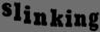

Result: 	 ALEPPO99999999999999999


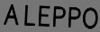

Result: 	 FWENDE999999999999999999


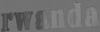

Result: 	 NATHANS99999999999999999


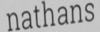

Result: 	 HALLO999999999999999999


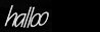

Result: 	 HURLS9999999999999999999


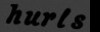

Result: 	 DOWNSIZE9999999999999999


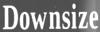

Result: 	 ROBOTIC99999999999999999


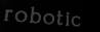

Result: 	 SLOPPY99999999999999999


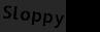

Result: 	 HERMITE99999999999999999


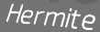

In [11]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

In [12]:
! pip install keras-ocr

In [13]:
! wget -P ~/aiffel/ocr https://aiffelstaticprd.blob.core.windows.net/media/original_images/sample.jpg


--2020-11-25 18:13:55--  https://aiffelstaticprd.blob.core.windows.net/media/original_images/sample.jpg
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98665 (96K) [image/jpeg]
Saving to: ‘/home/aiffel/aiffel/ocr/sample.jpg’

sample.jpg          100%[===================>]  96.35K  --.-KB/s    in 0.02s   

2020-11-25 18:13:55 (4.55 MB/s) - ‘/home/aiffel/aiffel/ocr/sample.jpg’ saved [98665/98665]



In [167]:
from keras_ocr.detection import Detector
SAMPLE_IMG_PATH = '/home/aiffel/aiffel/ocr/sample.jpg'
detector = Detector()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5


In [168]:
from PIL import Image, ImageDraw


def detect_text(img_path):
    # TODO

        # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    img_pil = Image.open(SAMPLE_IMG_PATH)
    img_draw = ImageDraw.Draw(img_pil)
    
    ocr_result = detector.detect([img_path])
        # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = [ocr_result[0][1]]
        # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return img_pil, cropped_imgs

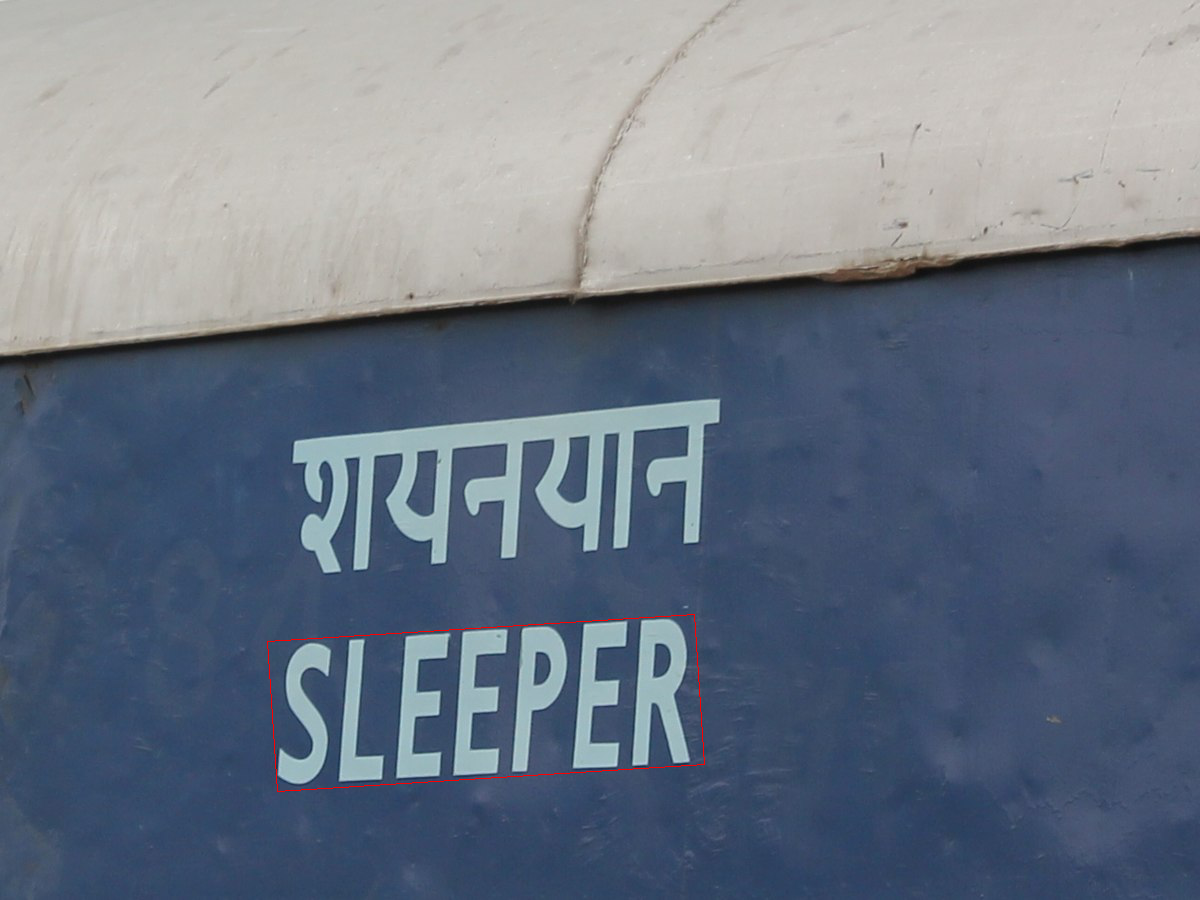

In [169]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [170]:
from keras_ocr.recognition import Recognizer
import numpy as np
def recognize_img(pil_img):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    img = np.array(pil_img)
    recognizer=Recognizer()
    result = recognizer.recognize(img)
    print(result)

In [171]:
for _img in cropped_img:
    recognize_img(_img)

Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5
sleeper
